<a href="https://colab.research.google.com/github/bulla1009/RainfallEstimation/blob/main/DWR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

REAL TIME RAINFALL ESTIMATION USING Z VALUES

The raw data was in the form of NetCDF files, I converted each file to a single data point which corresponded to the position of the rain gauge. These files can then be easily transferred and processed


The Rain gauge location corresponded to 299 th Azimuth Angle and 7 th range bin w.r.t location of the DWR Radar. These values did not change with elevation most of the time. However, in 16 and 21 degrees , it shifted to 8 th range bin

In [ ]:
import pandas as pd
import os

In [ ]:
%ls

drive/  sample_data/


First , I am concatenating every file where Cumulative Rainfall was greater than 10cm

In [ ]:
directory = '/content/drive/MyDrive/IGCAR/Anupuram'
files = os.listdir(directory)
big_df = pd.DataFrame()
for file in files:
  file_path = os.path.join(directory, file)
  df =  pd.read_csv(file_path)
  big_df = pd.concat([big_df,df],ignore_index = True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
big_df

,Unnamed: 0,dBZ,ZDR,KDP,time,elevation
0,0,-8.525041,NaN,0.0,2023-09-11-101803,16.0.
1,1,-1.109348,2.012845,0.0,2023-09-11-064745,2.0.
2,2,-5.463423,2.335651,0.0,2023-09-11-064327,6.0.
3,3,-13.083896,1.387549,0.0,2023-09-11-100240,12.0.
4,4,0.000000,NaN,0.0,2023-09-11-044035,16.0.
...,...,...,...,...,...,...
4547,608,-8.212836,NaN,NaN,2023-11-14-234624,16.0.
4548,609,0.404676,NaN,NaN,2023-11-14-234659,21.0.
4549,610,5.547655,NaN,NaN,2023-11-14-234755,0.2.
4550,611,-0.176092,NaN,NaN,2023-11-14-234828,1.0.


In [ ]:
big_df['time'] = pd.to_datetime(big_df['time'])

In [ ]:
big_df = big_df.sort_values(by = 'time')

In [ ]:
big_df['time'] = big_df['time'].dt.tz_localize('UTC')
big_df['time'] = big_df['time'].dt.tz_convert('Asia/Kolkata')


In [ ]:
big_df['time'] = big_df['time'].dt.tz_localize(None)

In [ ]:
big_df['elevation'] = big_df['elevation'].str.rstrip('.').astype(float)

In [ ]:
big_df = big_df.reset_index()

In [ ]:
big_df.drop(columns = ['index','Unnamed: 0'],inplace = True)

In [ ]:
big_df

,dBZ,ZDR,KDP,time,elevation
0,0.000000,NaN,0.000000,2023-05-01 10:23:05,0.2
1,0.000000,NaN,0.000000,2023-05-01 10:23:37,1.0
2,0.000000,NaN,0.000000,2023-05-01 10:24:10,2.0
3,0.000000,NaN,0.000000,2023-05-01 10:24:43,3.0
4,0.000000,NaN,0.000000,2023-05-01 10:25:16,4.0
...,...,...,...,...,...
4547,19.348431,0.227688,0.177254,2023-12-04 16:03:43,1.0
4548,25.777153,-0.445558,0.582027,2023-12-04 16:04:15,2.0
4549,24.994965,-0.437240,0.058376,2023-12-04 16:04:48,3.0
4550,24.672689,0.093605,0.059252,2023-12-04 16:05:21,4.0


AGGREGATING THE 250 KM SCANS

In [ ]:
max = []
times = []

for i in range(len(big_df)-10):
  if big_df['elevation'][i] == 0.2 and big_df['elevation'][i+9] == 21.0: # this denotes a 250 KM scan
    run = big_df['dBZ'][i:i+9]
    max.append(run.max())
    times.append(big_df['time'][i+9])
df_selected = pd.DataFrame()
df_selected['max'] = max
df_selected['time'] = times

In [ ]:
df_selected.columns

Index(['max', 'mean', 'median', 'maxele', 'time'], dtype='object')

In [ ]:
filtered_df = df_selected[df_selected['time'].dt.strftime('%Y-%m-%d') == '2023-12-04']

In [ ]:
len(filtered_df)

45

In [ ]:
df_selected['rounded_time'] = (df_selected['time'] - pd.to_timedelta(5, unit='m')).round('10min') # fit the date in the format of rain gauge data

In [ ]:
df_y = pd.read_excel('/content/drive/MyDrive/IGCAR/y_vals/raingauge_anupuram.xlsx')

In [ ]:
df_y

,date,time,R,CR
0,2023-01-01,00:00:01,0.0,0.0
1,2023-01-01,00:10:00,0.0,0.0
2,2023-01-01,00:20:00,0.0,0.0
3,2023-01-01,00:30:00,0.0,0.0
4,2023-01-01,00:40:00,0.0,0.0
...,...,...,...,...
52301,2023-12-31,23:10:00,0.0,0.0
52302,2023-12-31,23:20:00,0.0,0.0
52303,2023-12-31,23:30:00,0.0,0.0
52304,2023-12-31,23:40:00,0.0,0.0


In [ ]:
df_y.columns

Index(['date', 'time', 'R', 'CR'], dtype='object')

In [ ]:
df_y['date'] = df_y['date'].astype(str)
df_y['time'] = df_y['time'].astype(str)

In [ ]:
df_y.dropna(inplace = True)

In [ ]:
len(df_y)

46059

In [ ]:
df_y['date'] = pd.to_datetime(df_y['date'])

In [ ]:
df_y['date'] = df_y['date'].dt.date

In [ ]:
df_y['datetime'] = pd.to_datetime(df_y['date'] + ' ' + df_y['time'])

In [ ]:
df_y.columns

Index(['date', 'time', 'R', 'CR', 'datetime'], dtype='object')

In [ ]:
df_y['datetime']

0       2023-01-01 00:00:00
1       2023-01-01 00:10:00
2       2023-01-01 00:20:00
3       2023-01-01 00:30:01
4       2023-01-01 00:40:01
                ...        
46065   2023-12-31 23:10:00
46066   2023-12-31 23:20:00
46067   2023-12-31 23:30:00
46068   2023-12-31 23:40:00
46069   2023-12-31 23:50:00
Name: datetime, Length: 46059, dtype: datetime64[ns]

In [ ]:
df_selected.columns

Index(['max', 'mean', 'median', 'maxele', 'time', 'rounded_time'], dtype='object')

In [ ]:
len(df_selected)

146

In [ ]:
df_selected['rounded_time'] = pd.to_datetime(df_selected['rounded_time'])

In [ ]:
df_y['datetime'] = pd.to_datetime(df_y['datetime'])

In [ ]:
df_selected['rounded_time'] = df_selected['rounded_time'].dt.floor('T')
df_y['datetime'] = df_y['datetime'].dt.floor('T')

JOINING Z AND R

In [ ]:
df_xy = pd.DataFrame()
max_vals = []
mean_vals = []
median_vals = []
y_vals = []
times = []
for i in range(len(df_selected)):
  cnt = 0
  for j in range(len(df_y)):
    if df_selected['rounded_time'].iloc[i] == df_y['datetime'].iloc[j]:
      cnt += 1
      max_vals.append(df_selected['max'][i])
      mean_vals.append(df_selected['mean'][i])
      median_vals.append(df_selected['median'][i])
      y_vals.append(df_y['R'][j])
      times.append(df_selected['rounded_time'][i])
  if cnt == 0:
    print(df_selected['rounded_time'][i]) # there was no rain gauge observations at this time
df_xy['Z_max'] = max_vals
df_xy['Z_mean'] = mean_vals
df_xy['Z_median'] = median_vals
df_xy['R'] = y_vals
df_xy['time'] = times

In [ ]:
unique_dates = df_y[df_y['CR'] > 25]['date'].unique()
unique_dates

array(['2023-05-02', '2023-06-06', '2023-07-03', '2023-08-12',
       '2023-09-03', '2023-11-13', '2023-11-14', '2023-12-03',
       '2023-12-04', '2023-12-15', '2023-12-25'], dtype=object)

OBSERVING Z-R RELATIONSHIP ON 4th DEC

In [ ]:
df_4dec = df_nonzero[df_nonzero['time'].dt.strftime('%Y-%m-%d') == '2023-12-04']

NameError: name 'df_nonzero' is not defined

In [ ]:
unique_time = df_4dec['time'].unique()

In [ ]:
len(unique_time)

36

In [ ]:
grouped_df = df_4dec.groupby('time').mean().reset_index() # grouping those observations which have the same time window

In [ ]:
len(grouped_df)

34

In [ ]:
import matplotlib.pyplot as plt

I have used three aggregating functions - max(), mean() and median() , the results are shown

MAX

In [ ]:
df_nonzero = df_xy[df_xy['R']>0]
grouped_df = df_nonzero.groupby('time').mean().reset_index() # grouping those observations which have the same time window

MAX

Intercept: 24.611838283298077
Coefficient: 1.672839707828381


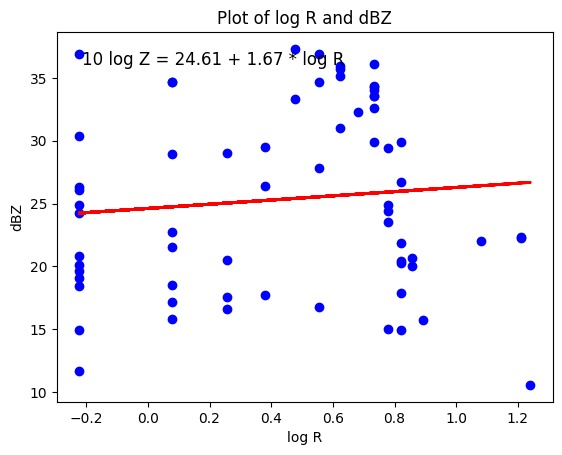

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Assuming grouped_df is your DataFrame and contains the required columns
R_data = grouped_df['R'].values * 6  # scale by 6 to convert to mm/hr
Z_data = grouped_df['Z_max'].values

# Log transform R_data to base 10
log_R_data = np.log10(R_data)

# Reshape data for linear regression
log_R_data_reshaped = log_R_data.reshape(-1, 1)
Z_data_reshaped = Z_data.reshape(-1, 1)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(log_R_data_reshaped, Z_data_reshaped)

# Get the coefficients
intercept = model.intercept_[0]
coefficient = model.coef_[0][0]

# Print the coefficients
print(f"Intercept: {intercept}")
print(f"Coefficient: {coefficient}")

# Generate predictions
Z_data_pred = model.predict(log_R_data_reshaped)

# Plotting the data and the regression line
plt.scatter(log_R_data, Z_data, color='blue', label='Original data')
plt.plot(log_R_data, Z_data_pred, color='red', linewidth=2, label='Fitted line')

# Equation of the best fit line
equation_text = f'10 log Z = {intercept:.2f} + {coefficient:.2f} * log R'
plt.text(0.05, 0.95, equation_text, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top')

plt.xlabel('log R')
plt.ylabel('dBZ')
plt.title('Plot of log R and dBZ')
#plt.legend()
plt.show()


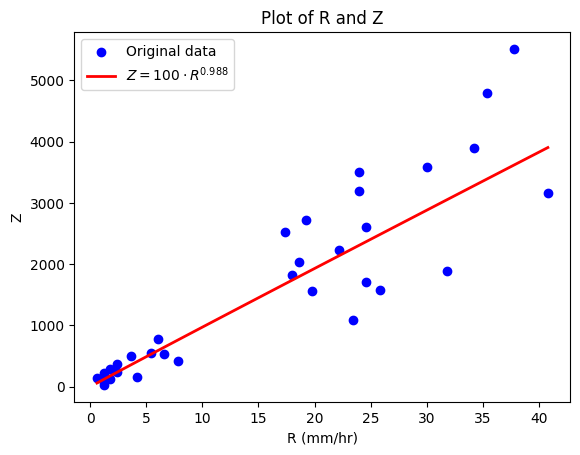

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming grouped_df is your DataFrame and contains the required columns
R_data = grouped_df['R'].values * 6  # scale by 6 to convert to mm/hr
Z_data = grouped_df['Z_max'].values

# Calculate Z_actual from Z_data
Z_actual = np.power(10, Z_data / 10)

# Define the curve Z = 2 * R^0.429
R_curve = np.linspace(R_data.min(), R_data.max(), 100)
Z_curve = 100 * np.power(R_curve, 0.988)

# Plotting the data and the curve
plt.scatter(R_data, Z_actual, color='blue', label='Original data')
plt.plot(R_curve, Z_curve, color='red', linewidth=2, label='$Z = 100 \cdot R^{0.988}$')

plt.xlabel('R (mm/hr)')
plt.ylabel('Z')
plt.title('Plot of R and Z')
plt.legend()
plt.show()

MEDIAN

In [ ]:
%pwd

'/content'

Now, doing the same for Anapuram Values

In [ ]:
directory = '/content/drive/MyDrive/IGCAR/Anupuram'
files = os.listdir(directory)
big_df = pd.DataFrame()
for file in files:
  file_path = os.path.join(directory, file)
  df =  pd.read_csv(file_path)
  big_df = pd.concat([big_df,df],ignore_index = True)

In [ ]:
big_df

,Unnamed: 0,dBZ,time,elevation
0,0,0.000000,2023-11-14-000914,0.2.
1,1,0.000000,2023-11-14-000947,1.0.
2,2,10.821558,2023-11-14-001020,2.0.
3,3,16.521805,2023-11-14-001052,3.0.
4,4,12.597430,2023-11-14-001125,4.0.
...,...,...,...,...
1205,592,19.645435,2023-12-04-103343,1.0.
1206,593,0.000000,2023-12-04-103415,2.0.
1207,594,26.189522,2023-12-04-103448,3.0.
1208,595,25.149288,2023-12-04-103521,4.0.


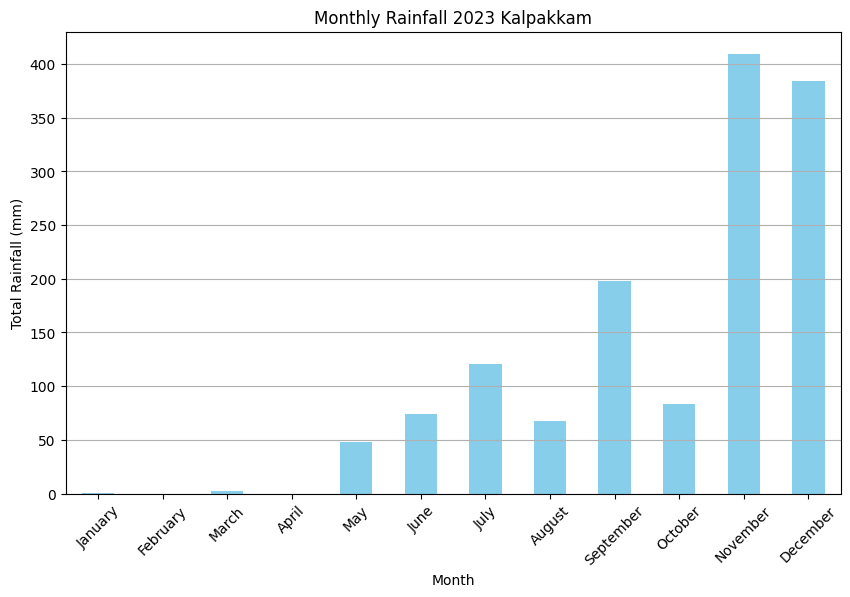

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = '/content/drive/MyDrive/IGCAR/y_vals/raingauge.xlsx'  # Update this path to the location of your file
rainfall_data = pd.read_excel(file_path)

# Combine date and time into a single datetime column
rainfall_data['datetime'] = pd.to_datetime(rainfall_data['date'].astype(str) + ' ' + rainfall_data['time'].astype(str))

# Set datetime as the index
rainfall_data.set_index('datetime', inplace=True)

# Resample the data to get monthly total rainfall
monthly_rainfall = rainfall_data['R'].resample('M').sum()

# Extract month names for labeling
monthly_rainfall.index = monthly_rainfall.index.strftime('%B')

# Generate the bar plot with updated title
plt.figure(figsize=(10, 6))
monthly_rainfall.plot(kind='bar', color='skyblue')
plt.title('Monthly Rainfall 2023 Kalpakkam')
plt.xlabel('Month')
plt.ylabel('Total Rainfall (mm)')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Display the plot
plt.show()
